In [1]:
import re
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import PredictionErrorDisplay
import xgboost
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('jr')
plt.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams["axes.unicode_minus"] = False

In [3]:
pal = sns.color_palette()
cbpal = sns.color_palette("colorblind")
clnsig_pal = {"Pathogenic/Likely_pathogenic":cbpal[3],"Benign/Likely_benign":cbpal[0], "Conflicting":pal[4], "VUS":pal[4],"Unannotated":cbpal[-3]}

# Load data

In [5]:
ukbb_scores = pd.read_csv('../Fig5c/TableSX_tiling_screen_UKBmerged.20230817.alpha_fixed.csv')
fuse_scores = pd.read_csv("LDLR_FUSE_scores_from_BEAN_081723.csv")
cons_data = pd.read_excel("../../resources/LDLR/LDLR_DMS_dbNSFP_050522.xlsx")

In [6]:
cons_data = pd.read_excel("../../resources/LDLR/LDLR_DMS_dbNSFP_050522.xlsx")

In [7]:
aa_cons = cons_data[['aapos', 'aaref', 'aaalt', 'phyloP100way_vertebrate']].groupby(['aapos', 'aaref', 'aaalt']).mean().reset_index()

In [8]:
fuse_scores['aastr'] = fuse_scores.gene_aa_str.map(lambda s: s.split("---")[-1])

In [9]:
ukb_annot = pd.read_csv("../../resources/UKBB/LDLR_FUSE_scores_from_BEAN_081123_sd05.csv")

ukb_annot["aastr"] = ukb_annot.aaref + ukb_annot.aapos.map(lambda x: int(x) if not np.isnan(x) else -1).astype(str) + ukb_annot.aaalt

In [10]:
ukbb_scores.loc[ukbb_scores.coding == "coding", "aapos"] = ukbb_scores.loc[ukbb_scores.coding == "coding", "pos"].map(lambda s: int(s[1:]))
ukbb_scores.loc[ukbb_scores.coding == "coding", "aaref"] = ukbb_scores.loc[ukbb_scores.coding == "coding", "ref"]
ukbb_scores.loc[ukbb_scores.coding == "coding", "aaalt"] = ukbb_scores.loc[ukbb_scores.coding == "coding", "alt"]

In [11]:
ukbb_scores = ukbb_scores.merge(fuse_scores[["aastr", "final_score_lite", "final_score"]], on="aastr")

In [12]:
ukbb_scores.ClinicalSignificance.value_counts()

Likely_pathogenic                               84
Pathogenic/Likely_pathogenic                    35
Conflicting_interpretations_of_pathogenicity    27
Uncertain_significance                          16
Pathogenic                                      12
Likely_benign                                   10
not_provided                                     6
Benign                                           3
Benign/Likely_benign                             2
Name: ClinicalSignificance, dtype: int64

In [14]:
ukbb_scores["clinvar_annot_4"] = "Unannotated"
ukbb_scores.loc[ukbb_scores.ClinicalSignificance.isin(["Pathogenic", "Likely_pathogenic", "Pathogenic/Likely_pathogenic"]), "clinvar_annot_4"] = "Pathogenic/Likely_pathogenic"
ukbb_scores.loc[ukbb_scores.ClinicalSignificance.isin(["Benign", "Likely_benign", "Benign/Likely_benign"]), "clinvar_annot_4"] = "Benign/Likely_benign"
ukbb_scores.loc[ukbb_scores.ClinicalSignificance == "Conflicting_interpretations_of_pathogenicity", "clinvar_annot_4"] = "Conflicting"
ukbb_scores.loc[ukbb_scores.ClinicalSignificance == "Uncertain_significance", "clinvar_annot_4"] = "VUS"
ukbb_scores.loc[ukbb_scores.clinvar_annot_4.isnull(), "clinvar_annot_4"] = "Unannotated"

## Predicting LDL-C levels in observed variants

In [15]:
scores_merged = ukbb_scores.loc[~ukbb_scores.mean_LDL.isnull()].merge(aa_cons, on=['aapos', 'aaref', 'aaalt'], how='left')

In [16]:
obs_df = scores_merged.loc[(~scores_merged.final_score_lite.isnull())]
y=obs_df.mean_LDL

In [17]:
len(obs_df.mean_LDL)

76

In [18]:
X=obs_df[["final_score", "phyloP100way_vertebrate"]].values
model = xgboost.XGBRegressor()
y_pred = cross_val_predict(model, X, y, cv=10)
R_pea = np.corrcoef(y, y_pred)[0, 1]
R_spe = scipy.stats.spearmanr(y, y_pred).correlation
rmse = np.sqrt(((y-y_pred)**2).mean())

X=obs_df[["final_score"]].values
model = xgboost.XGBRegressor()
y_pred = cross_val_predict(model, X, y, cv=10)
R_pea_fuse = np.corrcoef(y, y_pred)[0, 1]
R_spe_fuse = scipy.stats.spearmanr(y, y_pred).correlation
rmse_fuse = np.sqrt(((y-y_pred)**2).mean())

X=obs_df[["phyloP100way_vertebrate"]].values
model = xgboost.XGBRegressor()
y_pred = cross_val_predict(model, X, y, cv=10)
R_pea_cons = np.corrcoef(y, y_pred)[0, 1]
R_spe_cons = scipy.stats.spearmanr(y, y_pred).correlation
rmse_cons = np.sqrt(((y-y_pred)**2).mean())

df = pd.DataFrame({"Spearman R":[R_spe, R_spe_fuse, R_spe_cons], "Pearson R":[R_pea, R_pea_fuse, R_pea_cons], "RMSE":[rmse, rmse_fuse, rmse_cons]}, index=["FUSE+PhastCons", "FUSE", "PhastCons"]).reset_index()

In [19]:
df

,index,Spearman R,Pearson R,RMSE
0,FUSE+PhastCons,0.475489,0.607567,38.973442
1,FUSE,0.291446,0.354623,49.135357
2,PhastCons,0.423518,0.532479,47.235507


In [20]:
obs_df = scores_merged.loc[(~scores_merged.final_score_lite.isnull()) & (~scores_merged.mean_LDL.isnull())]
y=obs_df.mean_LDL
X=obs_df[["final_score", "phyloP100way_vertebrate"]].values
model = xgboost.XGBRegressor()
y_pred = cross_val_predict(model, X, y, cv=10)
R_pea = np.corrcoef(y, y_pred)[0, 1]
R_spe = scipy.stats.spearmanr(y, y_pred).correlation
rmse = np.sqrt(((y-y_pred)**2).mean())
print(R_pea, R_spe, rmse)

0.6075674360750101 0.4754887218045113 38.97344159363474


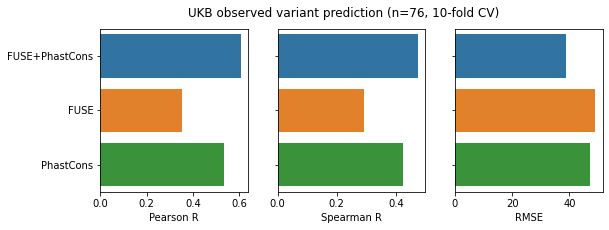

In [21]:
fig, ax = plt.subplots(1,3, figsize=(9, 3), sharey=True)
sns.barplot(df, y="index", x="Pearson R", ax=ax[0], orient='h')
sns.barplot(df, y="index", x="Spearman R", ax=ax[1], orient='h')
sns.barplot(df, y="index", x="RMSE", ax=ax[2], orient='h')
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[2].set_ylabel("")
plt.suptitle("UKB observed variant prediction (n=76, 10-fold CV)")
fig.savefig("prediction_metrics_obs.pdf", bbox_inches="tight")

In [22]:
X=obs_df[["final_score", "phyloP100way_vertebrate"]].values
model = xgboost.XGBRegressor()
y_pred = cross_val_predict(model, X, y, cv=10)

In [23]:
obs_df['y_pred'] = y_pred
scores_merged.loc[(~scores_merged.final_score_lite.isnull()) & (~scores_merged.mean_LDL.isnull()), "y_pred_obs"] = y_pred

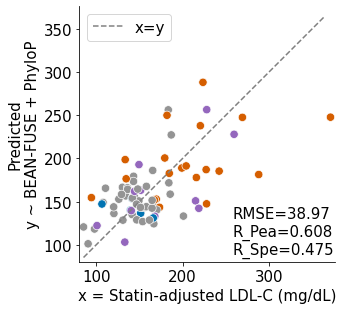

In [25]:
plt.style.use('jr')
fig, ax = plt.subplots(figsize=(5,5))

pdf = obs_df

ycol = 'y_pred'
sns.scatterplot(pdf, x = 'mean_LDL', y = ycol, ax = ax, hue = "clinvar_annot_4", palette = clnsig_pal, legend=False, s = 70)
ax.text(0.6, 0.03, f"R_Spe={pdf[['mean_LDL', ycol]].corr('spearman').iloc[0, 1]:.3f}", transform = ax.transAxes)
ax.text(0.6, 0.1, f"R_Pea={pdf[['mean_LDL', ycol]].corr().iloc[0, 1]:.3f}", transform = ax.transAxes)
ax.text(0.6, 0.17, f"RMSE={np.sqrt(((y-y_pred)**2).mean()):.2f}", transform = ax.transAxes)
ax.set_ylabel("Predicted\ny ~ BEAN-FUSE + PhyloP")

xpt = np.arange(pdf[['mean_LDL', 'y_pred']].min().min(), pdf[['mean_LDL', 'y_pred']].max().max(), 10)
ax.plot(xpt, xpt, linestyle = '--', color='grey', label='x=y')
ax.set_xlim((pdf[['mean_LDL', 'y_pred']].min().min()-5, pdf[['mean_LDL', 'y_pred']].max().max()+5))
ax.set_ylim((pdf[['mean_LDL', 'y_pred']].min().min()-5, pdf[['mean_LDL', 'y_pred']].max().max()+5))
ax.legend()
plt.tight_layout()
ax.set_xlabel("x = Statin-adjusted LDL-C (mg/dL)")
ax.set_box_aspect(1)
sns.despine(top=True, right=True)
#fig.savefig("5i_predict_with_fuse_phylop_v3.pdf", bbox_inches="tight")

In [26]:
pdf.to_csv("k_pred_df.csv")

## Predicting unobserved variants' LDL-C level

In [31]:
fuse_imputation = pd.read_csv("../../resources/UKBB/LDLR_UKBpatient_variants_meanLDL_functional_scores_clinvar_082223.csv")

In [32]:
fuse_imputation["clinvar_annot_4"] = "Unannotated"
fuse_imputation.loc[fuse_imputation.ClinicalSignificance.isin(["Pathogenic", "Likely pathogenic", "Pathogenic/Likely pathogenic"]), "clinvar_annot_4"] = "Pathogenic/Likely_pathogenic"
fuse_imputation.loc[fuse_imputation.ClinicalSignificance.isin(["Benign", "Likely benign", "Benign/Likely benign"]), "clinvar_annot_4"] = "Benign/Likely_benign"
fuse_imputation.loc[fuse_imputation.ClinicalSignificance == "Conflicting interpretations of pathogenicity", "clinvar_annot_4"] = "Conflicting"
fuse_imputation.loc[fuse_imputation.ClinicalSignificance == "Uncertain significance", "clinvar_annot_4"] = "VUS"
fuse_imputation.loc[fuse_imputation.clinvar_annot_4.isnull(), "clinvar_annot_4"] = "Unannotated"

In [33]:
fuse_imputation

,variant,aapos,aaref,aaalt,norm_raw_score,final_score_lite,final_score,mean_LDL,ClinicalSignificance,clinvar_annot_4
0,19-11100226-G-A,24,G,D,NaN,NaN,NaN,144.973000,NaN,Unannotated
1,19-11100228-G-A,25,D,N,NaN,NaN,0.223872,135.116196,Uncertain significance,VUS
2,19-11100236-C-G,27,C,W,NaN,NaN,1.555278,229.801667,Pathogenic,Pathogenic/Likely_pathogenic
3,19-11100237-G-A,28,E,K,NaN,NaN,0.325243,154.389000,Uncertain significance,VUS
4,19-11100241-G-C,29,R,T,NaN,NaN,0.206866,137.240500,NaN,Unannotated
...,...,...,...,...,...,...,...,...,...,...
457,19-11131293-A-G,854,S,G,0.273426,0.183435,0.183435,100.773000,Uncertain significance,VUS
458,19-11131296-C-A,855,L,M,NaN,NaN,0.061666,135.035000,Uncertain significance,VUS
459,19-11131299-G-C,856,E,Q,NaN,NaN,-0.217866,141.879000,NaN,Unannotated
460,19-11131308-G-A,859,V,M,NaN,NaN,0.156254,149.949406,Likely benign,Benign/Likely_benign


In [34]:
fuse_imputation = fuse_imputation.merge(aa_cons, on=['aapos', 'aaref', 'aaalt'], how='left')

In [35]:
unobs_df = fuse_imputation.loc[(fuse_imputation.final_score_lite.isnull()) & (~fuse_imputation.final_score.isnull()) ]
len(unobs_df)

282

In [74]:
unobs_df

,variant,aapos,aaref,aaalt,norm_raw_score,final_score_lite,final_score,mean_LDL,ClinicalSignificance,clinvar_annot_4,phyloP100way_vertebrate
1,19-11100228-G-A,25,D,N,NaN,NaN,0.223872,135.116196,Uncertain significance,VUS,0.690
2,19-11100236-C-G,27,C,W,NaN,NaN,1.555278,229.801667,Pathogenic,Pathogenic/Likely_pathogenic,-0.152
3,19-11100237-G-A,28,E,K,NaN,NaN,0.325243,154.389000,Uncertain significance,VUS,0.342
4,19-11100241-G-C,29,R,T,NaN,NaN,0.206866,137.240500,NaN,Unannotated,1.798
5,19-11100241-G-T,29,R,I,NaN,NaN,0.247299,143.503000,NaN,Unannotated,1.798
...,...,...,...,...,...,...,...,...,...,...,...
455,19-11131289-G-C,852,M,I,NaN,NaN,0.118998,123.473000,NaN,Unannotated,1.628
456,19-11131289-G-T,852,M,I,NaN,NaN,0.118998,142.958714,NaN,Unannotated,1.628
458,19-11131296-C-A,855,L,M,NaN,NaN,0.061666,135.035000,Uncertain significance,VUS,0.640
459,19-11131299-G-C,856,E,Q,NaN,NaN,-0.217866,141.879000,NaN,Unannotated,7.346


In [75]:
y = obs_df.mean_LDL
X = obs_df[["final_score", "phyloP100way_vertebrate"]].values
model = xgboost.XGBRegressor()
model.fit(X, y)
y_pred = model.predict(unobs_df[["final_score", "phyloP100way_vertebrate"]].values)
unobs_df["y_unobs_pred"] = y_pred
fuse_imputation.loc[(fuse_imputation.final_score_lite.isnull()) & (~fuse_imputation.final_score.isnull()), "y_pred_unobs"] = y_pred

<ipython-input-75-0c249b62a973>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unobs_df["y_unobs_pred"] = y_pred


In [76]:
y = obs_df.mean_LDL
y_true = unobs_df.mean_LDL
X=obs_df[["final_score", "phyloP100way_vertebrate"]].values
model = xgboost.XGBRegressor()
model.fit(X, y)
y_pred = model.predict(unobs_df[["final_score", "phyloP100way_vertebrate"]].values)
R_pea = np.corrcoef(y_true, y_pred)[0, 1]
R_spe = scipy.stats.spearmanr(y_true, y_pred).correlation
rmse = np.sqrt(((y_true-y_pred)**2).mean())

X=obs_df[["final_score"]].values
model = xgboost.XGBRegressor()
model.fit(X, y)
y_pred = model.predict(unobs_df[["final_score"]].values)
R_pea_fuse = np.corrcoef(y_true, y_pred)[0, 1]
R_spe_fuse = scipy.stats.spearmanr(y_true, y_pred).correlation
rmse_fuse = np.sqrt(((y_true-y_pred)**2).mean())

X=obs_df[["phyloP100way_vertebrate"]].values
model = xgboost.XGBRegressor()
model.fit(X, y)
y_pred = model.predict(unobs_df[["phyloP100way_vertebrate"]].values)
R_pea_cons = np.corrcoef(y_true, y_pred)[0, 1]
R_spe_cons = scipy.stats.spearmanr(y_true, y_pred, nan_policy="omit").correlation
rmse_cons = np.sqrt(((y_true-y_pred)**2).mean())

df_unobs = pd.DataFrame({"Spearman R":[R_spe, R_spe_fuse, R_spe_cons], "Pearson R":[R_pea, R_pea_fuse, R_pea_cons], "RMSE":[rmse, rmse_fuse, rmse_cons]}, index=["FUSE+PhastCons", "FUSE", "PhastCons"]).reset_index()

In [77]:
y_true

1      135.116196
2      229.801667
3      154.389000
4      137.240500
5      143.503000
          ...    
455    123.473000
456    142.958714
458    135.035000
459    141.879000
460    149.949406
Name: mean_LDL, Length: 282, dtype: float64

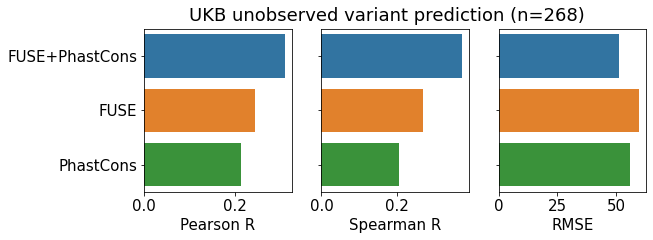

In [78]:
fig, ax = plt.subplots(1,3, figsize=(9, 3), sharey=True)
sns.barplot(df_unobs, y="index", x="Pearson R", ax=ax[0], orient='h')
sns.barplot(df_unobs, y="index", x="Spearman R", ax=ax[1], orient='h')
sns.barplot(df_unobs, y="index", x="RMSE", ax=ax[2], orient='h')
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[2].set_ylabel("")
plt.suptitle("UKB unobserved variant prediction (n=268)")
fig.savefig("prediction_metrics_unobs.pdf", bbox_inches="tight")

In [79]:
metric_df = df.set_index("index").join(df_unobs.set_index("index"), lsuffix="_obs", rsuffix="_unobs")
metric_df.to_csv("SX_prediction_metrics.csv")
metric_df

,Spearman R_obs,Pearson R_obs,RMSE_obs,Spearman R_unobs,Pearson R_unobs,RMSE_unobs
index,,,,,,
FUSE+PhastCons,0.475489,0.607567,38.973442,0.373950,0.309709,51.091960
FUSE,0.291446,0.354623,49.135357,0.271176,0.244550,59.930363
PhastCons,0.423518,0.532479,47.235507,0.207314,0.213139,56.111415


In [36]:
y = obs_df.mean_LDL
y_true = unobs_df.mean_LDL
X=obs_df[["final_score", "phyloP100way_vertebrate"]].values
model = xgboost.XGBRegressor()
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [38]:
unobs_df['y_unobs_pred'] = model.predict(unobs_df[["final_score", "phyloP100way_vertebrate"]].values)

<ipython-input-38-3a23b16246f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unobs_df['y_unobs_pred'] = model.predict(unobs_df[["final_score", "phyloP100way_vertebrate"]].values)


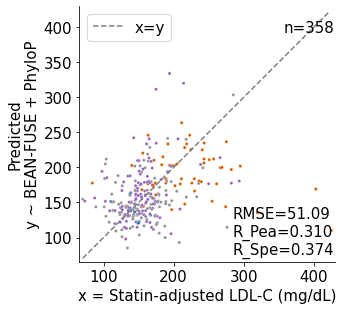

In [83]:
plt.style.use('jr')
fig, ax = plt.subplots(figsize=(5,5))

pdf = unobs_df
ycol = 'y_unobs_pred'
sns.scatterplot(pdf, x = 'mean_LDL', y = ycol, ax = ax, hue = "clinvar_annot_4", palette = clnsig_pal, legend=False, s=10)
ax.text(0.6, 0.03, f"R_Spe={pdf[['mean_LDL', ycol]].corr('spearman').iloc[0, 1]:.3f}", transform = ax.transAxes)
ax.text(0.6, 0.1, f"R_Pea={pdf[['mean_LDL', ycol]].corr().iloc[0, 1]:.3f}", transform = ax.transAxes)
ax.text(0.6, 0.17, f"RMSE={np.sqrt(((pdf.mean_LDL-pdf[ycol])**2).mean()):.2f}", transform = ax.transAxes)
ax.set_ylabel("Predicted\ny ~ BEAN-FUSE + PhyloP")

xpt = np.arange(pdf[['mean_LDL', ycol]].min().min(), pdf[['mean_LDL', ycol]].max().max(), 10)
ax.plot(xpt, xpt, linestyle = '--', color='grey', label='x=y')
ax.set_xlim((pdf[['mean_LDL', ycol]].min().min()-5, pdf[['mean_LDL', ycol]].max().max()+5))
ax.set_ylim((pdf[['mean_LDL', ycol]].min().min()-5, pdf[['mean_LDL', ycol]].max().max()+5))
ax.legend()
plt.tight_layout()
ax.set_xlabel("x = Statin-adjusted LDL-C (mg/dL)")
ax.text(0.8, 0.9, f"n={len(fuse_imputation.loc[~fuse_imputation.final_score.isnull() & (~fuse_imputation.mean_LDL.isnull())])}", transform=ax.transAxes)

ax.set_box_aspect(1)
sns.despine(top=True, right=True)
fig.savefig("5i_predict_all_with_fuse_phylop_v3.pdf", bbox_inches="tight")

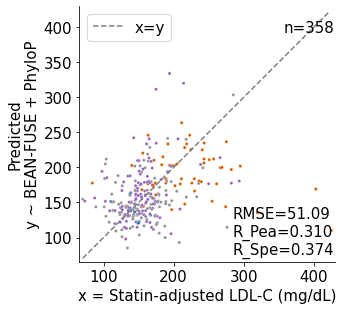

In [39]:
plt.style.use('jr')
fig, ax = plt.subplots(figsize=(5,5))

pdf = unobs_df
ycol = 'y_unobs_pred'
sns.scatterplot(pdf, x = 'mean_LDL', y = ycol, ax = ax, hue = "clinvar_annot_4", palette = clnsig_pal, legend=False, s=10)
ax.text(0.6, 0.03, f"R_Spe={pdf[['mean_LDL', ycol]].corr('spearman').iloc[0, 1]:.3f}", transform = ax.transAxes)
ax.text(0.6, 0.1, f"R_Pea={pdf[['mean_LDL', ycol]].corr().iloc[0, 1]:.3f}", transform = ax.transAxes)
ax.text(0.6, 0.17, f"RMSE={np.sqrt(((pdf.mean_LDL-pdf[ycol])**2).mean()):.2f}", transform = ax.transAxes)
ax.set_ylabel("Predicted\ny ~ BEAN-FUSE + PhyloP")

xpt = np.arange(pdf[['mean_LDL', ycol]].min().min(), pdf[['mean_LDL', ycol]].max().max(), 10)
ax.plot(xpt, xpt, linestyle = '--', color='grey', label='x=y')
ax.set_xlim((pdf[['mean_LDL', ycol]].min().min()-5, pdf[['mean_LDL', ycol]].max().max()+5))
ax.set_ylim((pdf[['mean_LDL', ycol]].min().min()-5, pdf[['mean_LDL', ycol]].max().max()+5))
ax.legend()
plt.tight_layout()
ax.set_xlabel("x = Statin-adjusted LDL-C (mg/dL)")
ax.text(0.8, 0.9, f"n={len(fuse_imputation.loc[~fuse_imputation.final_score.isnull() & (~fuse_imputation.mean_LDL.isnull())])}", transform=ax.transAxes)

ax.set_box_aspect(1)
sns.despine(top=True, right=True)
#fig.savefig("5i_predict_all_with_fuse_phylop_v3.pdf", bbox_inches="tight")

In [40]:
pdf[['mean_LDL', ycol]].to_csv("E9b.csv")